In [ ]:
%env CUDA_VISIBLE_DEVICES=""

In [2]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.vision.models import resnet34, resnet18
from fastai.data.transforms import *
from fastai.callback.core import *
from pathlib import Path
import numpy as np
import cv2
import os
import sys
import shutil
import re
import matplotlib.pyplot as plt
from segmentation_data import *

In [3]:
# TODO use segmentation_data.py instead
# dataset_dir = "/data/datasets/NLM-shenzhen-montgomery/original+pediatric"
# train_path = Path(os.path.join(dataset_dir, "train"))
# train_mask_fn = lambda x: train_path/"mask"/f"{x.stem}.png"

print("Dataset: ", dataset_dir)

train_files = get_image_files(os.path.join(dataset_dir, "train", "xray"))

Dataset:  /data/datasets/NLM-shenzhen-montgomery/original+pediatric


/data/datasets/NLM-shenzhen-montgomery/original+pediatric/train/xray/pediatric_other_1.2.840.113564.52.172.16.11.200.1040.20200504133102424_1.jpg
PILMask mode=L size=2208x2664
/data/datasets/NLM-shenzhen-montgomery/original+pediatric/train/xray/shenzhen_CHNCXR_0233_0.png
PILMask mode=L size=3000x2939
/data/datasets/NLM-shenzhen-montgomery/original+pediatric/train/xray/shenzhen_CHNCXR_0238_0.png
PILMask mode=L size=3000x2951


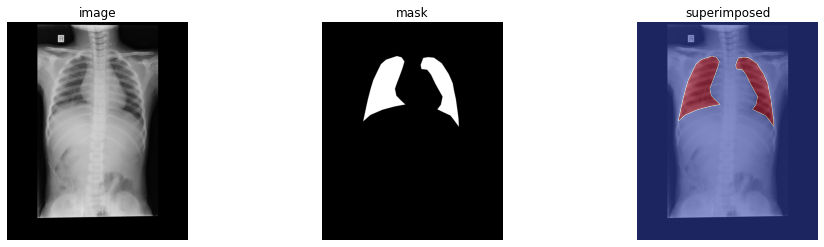

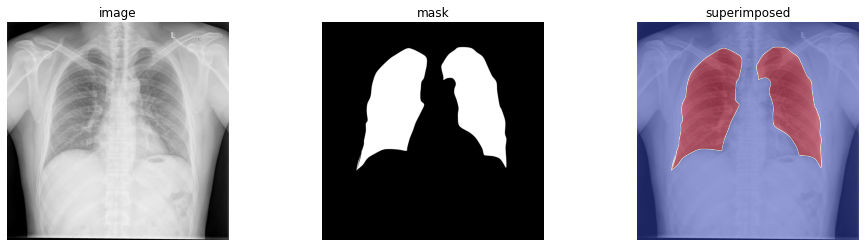

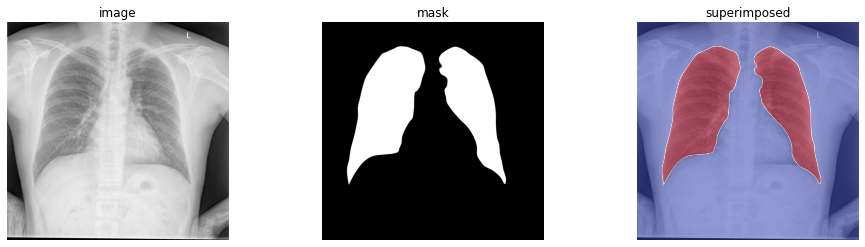

In [4]:
# for img_f in train_files:
#     tmask = Transform(PILMask.create)
#     mask = tmask(train_mask_fn(img_f))
#     if len(np.unique(mask)) > 2:
#         print(train_mask_fn(img_f))

def show_image(idx):
    img_f = train_files[idx]
    print(img_f)
    img = PILImage.create(img_f)
    tmask = Transform(PILMask.create)
    mask = tmask(train_mask_fn(img_f))
#     mask = open_mask(train_mask_fn(img_f))
    print(mask)

    _, axs = plt.subplots(1,3, figsize=(16,4))
    img.show(ctx=axs[0], title='image')
    mask.show(alpha=1, ctx=axs[1], cmap='gray', title='mask')
    img.show(ctx=axs[2], title='superimposed')
    mask.show(ctx=axs[2], cmap='coolwarm')

show_image(10)
show_image(160)
show_image(400)

[Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'zeros', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: , Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ]


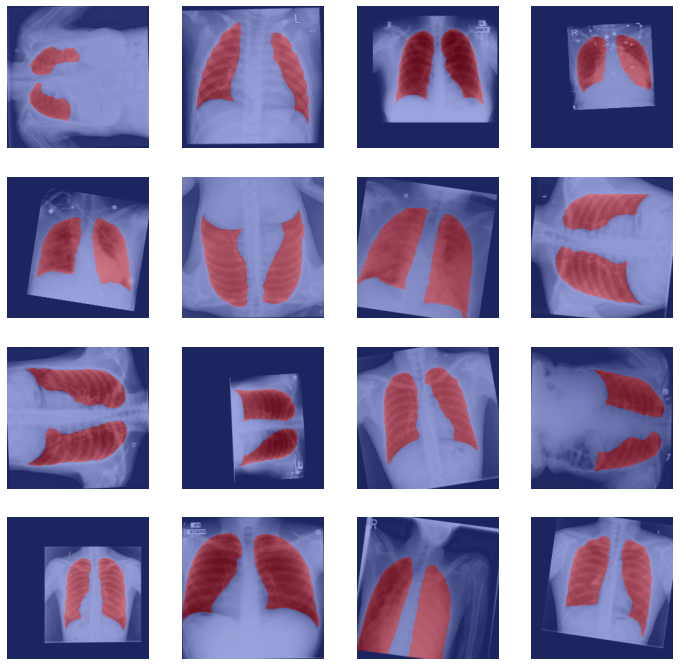

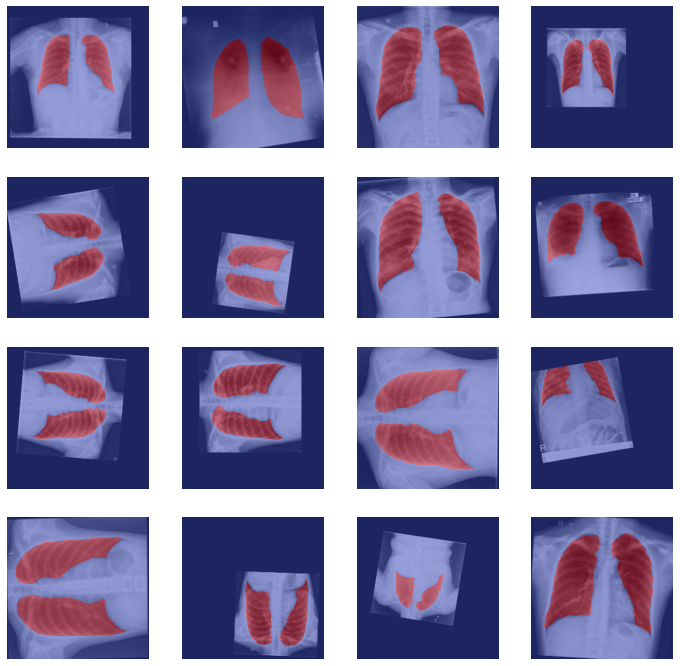

In [5]:
augmentation = aug_transforms(
  do_flip=True,
  flip_vert=True,
  max_rotate=10.,
  min_zoom=0.5,
  max_zoom=1.1,
  max_warp=0.0,
  pad_mode='zeros'
)

print(augmentation)

dls = SegmentationDataLoaders.from_label_func(train_path, train_files, train_mask_fn, valid_pct=0.1, bs=16, seed=2020, item_tfms=Resize(size=(224, 224), method="squish"), batch_tfms=augmentation)
dls.c = 2
dls.show_batch(max_n=16, vmin=0, vmax=1, cmap="coolwarm")
dls.show_batch(max_n=16, vmin=0, vmax=1, cmap="coolwarm")

In [6]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()

model_path = "/data/output/NLM_Shenzhen_Montgomery-01"
model_dir = "unet-resnet34"
learn = unet_learner(dls, resnet34, wd=1e-2, path=model_path, model_dir=model_dir)
# model_path = "/data/output/NLM_Shenzhen_Montgomery-01/unet-resnet34/best"
if os.path.exists(os.path.join(model_path, model_dir, "best.pth")):
    learn.load("best")

learn.summary()

DynamicUnet (Input shape: ['16 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 64 x 112 x 112  9,408      False     
________________________________________________________________
BatchNorm2d          16 x 64 x 112 x 112  128        True      
________________________________________________________________
ReLU                 16 x 64 x 112 x 112  0          False     
________________________________________________________________
MaxPool2d            16 x 64 x 56 x 56    0          False     
________________________________________________________________
Conv2d               16 x 64 x 56 x 56    36,864     False     
________________________________________________________________
BatchNorm2d          16 x 64 x 56 x 56    128        True      
________________________________________________________________
ReLU                 16 x 64 x 56 x 56    0          False     
________________________________________________

In [7]:
# lr_min, lr_steep = learn.lr_find() # find learning rate
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [8]:
def before_batch_cb(*args, **kwargs):
    batch_args = args
    batch_kwargs = kwargs
    print(args, kwargs, self)
    
callbacks = [
    SaveModelCallback(fname="best"),
    EarlyStoppingCallback(patience=8),
#     Callback(before_batch=before_batch_cb)
]
# learn.fit_one_cycle(50, cbs=callbacks, lr_max=max(lr_steep, lr_min))
learn.fit_one_cycle(50, cbs=callbacks, lr_max=1e-4)
# try:
#     learn.fit_one_cycle(50, cbs=callbacks, lr_max=1e-4)
# except Exception as e:
#     print(e)

epoch,train_loss,valid_loss,time
0,0.082274,0.052023,10:26
1,0.068084,0.051617,10:19
2,0.061326,0.049215,09:57
3,0.058648,0.052203,09:57
4,0.054932,0.048210,09:54
5,0.053853,0.042278,09:59
6,0.050610,0.040409,09:57
7,0.047819,0.040735,09:56
8,0.048164,0.041297,09:58
9,0.046917,0.043317,09:57


Better model found at epoch 0 with valid_loss value: 0.05202281475067139.
Better model found at epoch 1 with valid_loss value: 0.051616594195365906.
Better model found at epoch 2 with valid_loss value: 0.04921466484665871.
Better model found at epoch 4 with valid_loss value: 0.04820999503135681.
Better model found at epoch 5 with valid_loss value: 0.04227771237492561.
Better model found at epoch 6 with valid_loss value: 0.040408797562122345.
Better model found at epoch 10 with valid_loss value: 0.03931500390172005.
Better model found at epoch 14 with valid_loss value: 0.038470637053251266.
No improvement since epoch 14: early stopping


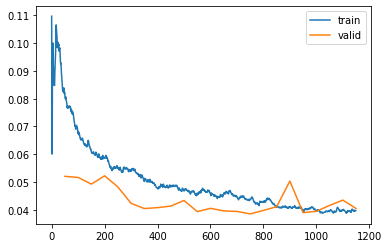

In [9]:
learn.recorder.plot_loss(0)

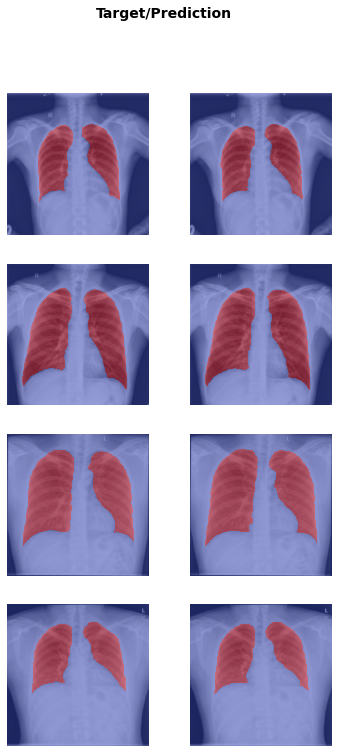

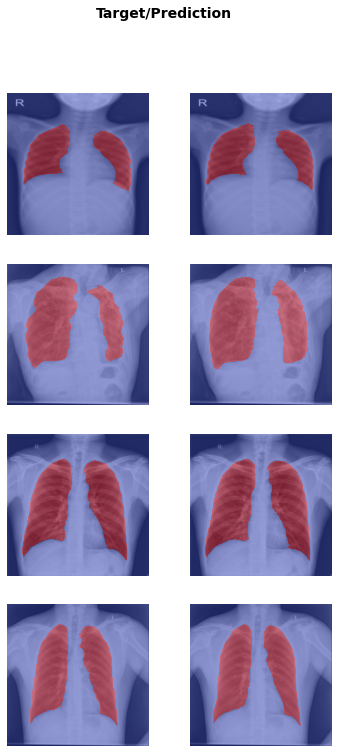

In [13]:
learn.load("best")
learn.freeze()

learn.show_results(max_n=16, vmin=0, vmax=1, cmap="coolwarm")
learn.show_results(max_n=16, vmin=0, vmax=1, cmap="coolwarm")

In [15]:
learn.export("segmentation-model.pkl")

In [16]:
from datetime import datetime as dt
import time

time.sleep(60)
# Save run as an HTML file
report_file = os.path.join(learn.path, learn.model_dir, "report_{:%Y%m%d_%H%M%S}.html".format(dt.now()))
print(f"Saving as: {report_file}")
os.system(f'jupyter nbconvert segmentation-train.ipynb --to html --output {report_file}')

Saving as: /data/output/NLM_Shenzhen_Montgomery-06/unet-resnet34/report_20201008_180206.html


0